# Getaround Analysis project - Pricing Optimization




Contents
--------
1. [Data loading](#loading)
2. [Preliminary EDA](#eda)
3. [Data preprocessing and utilities](#utils)
4. [Ridge regression](#linreg)
5. [Gradient Boosting model](#gbm)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from sklearn.compose import ColumnTransformer
from sklearn.metrics import (mean_squared_error,
                             r2_score,
                             mean_absolute_error,
                             mean_absolute_percentage_error)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder,
                                   StandardScaler,
                                   FunctionTransformer)
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor

## <a id="loading"></a> Data loading

The dataset conatining the features relevant to rental car princing is stored in the csv file `get_around_pricing_project.csv`.

In [2]:
df = pd.read_csv('./data/get_around_pricing_project.csv')
df = df.drop('Unnamed: 0', axis=1)
df

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4838,Toyota,39743,110,diesel,black,van,False,True,False,False,False,False,True,121
4839,Toyota,49832,100,diesel,grey,van,False,True,False,False,False,False,True,132
4840,Toyota,19633,110,diesel,grey,van,False,True,False,False,False,False,True,130
4841,Toyota,27920,110,diesel,brown,van,True,True,False,False,False,False,True,151


In [3]:
df.describe(include='all')

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
count,4843,4.843000e+03,4843.00000,4843,4843,4843,4843,4843,4843,4843,4843,4843,4843,4843.000000
unique,28,NaN,NaN,4,10,8,2,2,2,2,2,2,2,NaN
top,Citroën,NaN,NaN,diesel,black,estate,True,True,False,False,False,False,True,NaN
freq,969,NaN,NaN,4641,1633,1606,2662,3839,3865,3881,2613,3674,4514,NaN
mean,NaN,1.409628e+05,128.98823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121.214536
std,NaN,6.019674e+04,38.99336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.568268
min,NaN,-6.400000e+01,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.000000
25%,NaN,1.029135e+05,100.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.000000
50%,NaN,1.410800e+05,120.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119.000000
75%,NaN,1.751955e+05,135.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.000000


The dataset has 4843 rows, which correspond to distinct cars available on the platform. There is no missing data. However, we note the presence of an aberrant negative mileage. There are also outliers, for instance a max `mileage` of $10^6$, about $15\sigma$ from the mean.

The prediction target is `rental_price_per_day`, a quantitative variable.

We are in the presence of three categories of predictive features:
- Categorical variables: `model_key`, `fuel`, `paint_color`, `car_type`.
- Boolean variables: `private_parking_available`, `has_gps`, `has_air_conditioning`, `automatic_car`, `has_getaround_connect`, `has_speed_regulator`, `winter_tires`.
- Quantitative variables: `mileage`, `engine_power`.

In [4]:
cat_vars = ['model_key', 'fuel', 'paint_color', 'car_type']

bool_vars = ['private_parking_available', 'has_gps', 'has_air_conditioning',
             'automatic_car', 'has_getaround_connect', 'has_speed_regulator',
             'winter_tires']

quant_vars = ['mileage', 'engine_power']

## <a id="eda"></a> Preliminary data analysis

We begin with the usual exploratory data analysis, to gather insight and determine our preprocessing policy.

In [5]:
df['car_type'].value_counts()

car_type
estate         1606
sedan          1168
suv            1058
hatchback       699
subcompact      117
coupe           104
convertible      47
van              44
Name: count, dtype: int64

In [6]:
df['fuel'].value_counts()

fuel
diesel           4641
petrol            191
hybrid_petrol       8
electro             3
Name: count, dtype: int64

In [7]:
df['paint_color'].value_counts()

paint_color
black     1633
grey      1175
blue       710
white      538
brown      341
silver     329
red         52
beige       41
green       18
orange       6
Name: count, dtype: int64

In [8]:
df['model_key'].value_counts()

model_key
Citroën        969
Renault        916
BMW            827
Peugeot        642
Audi           526
Nissan         275
Mitsubishi     231
Mercedes        97
Volkswagen      65
Toyota          53
SEAT            46
Subaru          44
PGO             33
Ferrari         33
Opel            33
Maserati        18
Suzuki           8
Porsche          6
Ford             5
KIA Motors       3
Alfa Romeo       3
Fiat             2
Lexus            2
Lamborghini      2
Mazda            1
Honda            1
Mini             1
Yamaha           1
Name: count, dtype: int64

We note the presence of underrepresented categories for `fuel`, `paint_color` and `model_key`. This could be a problem during model training and evaluation, or worse, in production. For instance, in a train-test split, a given category could be absent from the train sample and thus would not be recognized during testing.

### Rental prices distributions vs car options

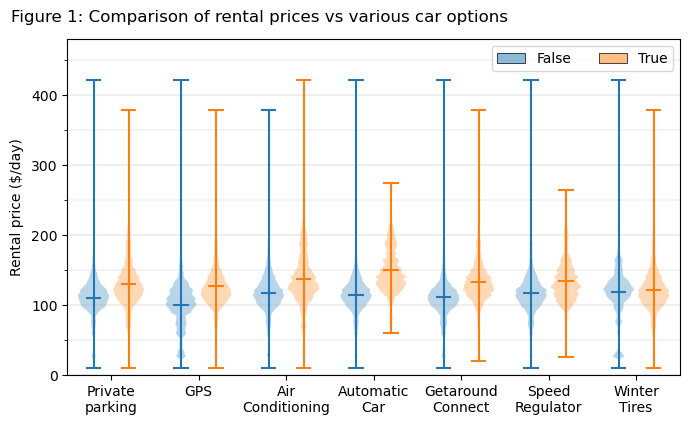

In [9]:
fig1, ax1 = plt.subplots(
    nrows=1, ncols=1, figsize=(7, 4.2), dpi=100,
    gridspec_kw={'left': 0.1, 'right': 0.975, 'top': 0.91, 'bottom': 0.11, 'hspace': 0.08})
fig1.suptitle("Figure 1: Comparison of rental prices vs various car options",
              x=0.02, ha='left')


vdata, vpos = [], []
vdata_true, vdata_false = [], []
for i, item in enumerate(bool_vars):
    for is_, gdf in df.groupby(item):
        if is_:
            vdata_true.append(gdf['rental_price_per_day'].to_numpy())
        else:
            vdata_false.append(gdf['rental_price_per_day'].to_numpy())

vplot_false = ax1.violinplot(vdata_false, positions=np.linspace(-0.2, i-0.2, i+1),
                             widths=0.36, showmeans=True, bw_method=0.05)
for elt in vplot_false['bodies']:
    elt.set_facecolor('#1F77B480')
for elt in ['cbars', 'cmaxes', 'cmins', 'cmeans']:
    vplot_false[elt].set_edgecolor('tab:blue')

vplot_true = ax1.violinplot(vdata_true, positions=np.linspace(0.2, i+0.2, i+1),
                            widths=0.36, showmeans=True, bw_method=0.05)
for elt in vplot_true['bodies']:
    elt.set_facecolor('#FF7F0E80')
for elt in ['cbars', 'cmaxes', 'cmins', 'cmeans']:
    vplot_true[elt].set_edgecolor('tab:orange')


ax1.set_xlim(-0.5, i+0.5)
ticks = ['Private\nparking', 'GPS', 'Air\nConditioning', 'Automatic\nCar',
         'Getaround\nConnect', 'Speed\nRegulator', 'Winter\nTires']
ax1.set_xticks(np.arange(0, len(ticks)), ticks, rotation=0)
ax1.set_ylim(0, 480)
ax1.set_yticks(np.arange(50, 500, 50), minor=True)
ax1.set_ylabel('Rental price ($/day)', labelpad=5)
ax1.grid(visible=True, axis='y', linewidth=0.3)
ax1.grid(visible=True, axis='y', which='minor', linewidth=0.2)

handles = [Patch(facecolor='#1F77B480', edgecolor='k', linewidth=0.5),
           Patch(facecolor='#FF7F0E80', edgecolor='k', linewidth=0.5)]
ax1.legend(handles=handles, labels=['False', 'True'], ncols=2)

plt.show()

Figure 1 presents violin plots of car rental price as a function of various car options. The presence of an option, such as a GPS or private parking affects the price positively, with an average price increase of about 10-20%. The only exception is that of winter tires, their presence do not affect the rental price.

### Correlation between non-categorical features

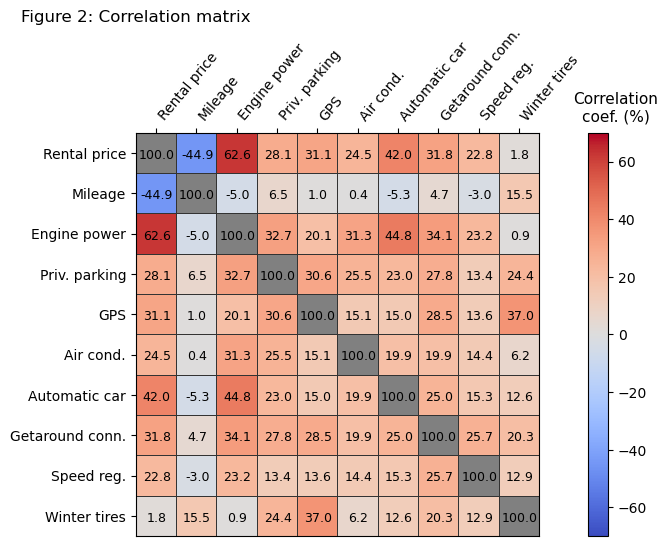

In [10]:
## Correlation matrix
df_ = df.loc[:, ['rental_price_per_day'] + quant_vars + bool_vars]
corr_df = df_.corr().to_numpy()

##
fig2, ax2 = plt.subplots(
    nrows=1, ncols=1, figsize=(6.6, 5.6), dpi=100,
    gridspec_kw={'left': 0.12, 'right': 0.88, 'top': 0.76, 'bottom': 0.04, 'wspace': 0.24})
cax2 = fig2.add_axes((0.88, 0.04, 0.03, 0.72))
fig2.suptitle("Figure 2: Correlation matrix",
              x=0.02, ha='left')


ax2.set_aspect('equal')
cmap2 = plt.get_cmap('coolwarm').copy()
cmap2.set_extremes(under='0.9', over='0.5')
heatmap = ax2.pcolormesh(corr_df[::-1]*100, cmap=cmap2, vmin=-70, vmax=70,
                             edgecolors='0.2', linewidth=0.5)

ax2.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ticklabels = ['Rental price', 'Mileage', 'Engine power',
              'Priv. parking', 'GPS', 'Air cond.', 'Automatic car',
              'Getaround conn.', 'Speed reg.', 'Winter tires']
ax2.set_xticks(np.linspace(0.5, 9.5, 10), ticklabels, rotation=50, ha='left')
ax2.set_yticks(np.linspace(9.5, 0.5, 10), ticklabels, rotation=0)

for (i, j), c in np.ndenumerate(corr_df[::-1]*100):
    ax2.text(j+0.52, i+0.45, f'{c:.1f}', ha='center', va='center', fontsize=9)

pos = ax2.get_position().bounds
x, y = pos[0], pos[1] + pos[3]

fig2.colorbar(heatmap, cax=cax2, orientation="vertical", ticklocation="right")
cax2.text(1.4, 1.03, 'Correlation\ncoef. (%)', fontsize=11, ha='center', transform=cax2.transAxes)


plt.show()

Figure 2 present the correlation matrix for non-categorical variables. The correlations are expressed in percents (%). The rental price is strongly correlated to the engine power, and in general with all additional car options, except winter tires. This result is intuitive: these features are associated to a higher car price, which directly reflects on the rental price. On the other hand, the car mileage is negatively correlated with rental price. A higher mileage means that the car is probably older, thus a higher risk of issues during rental. It is interesting to note that the mileage is not correlated to car options.

### Distribution of rental prices for the various categories

We now study the rental price distributions for each category. As mentioned above, some category are underrepresented. For each feature, we aggregate those categories with count less than 30 into an infrequent category `other`.

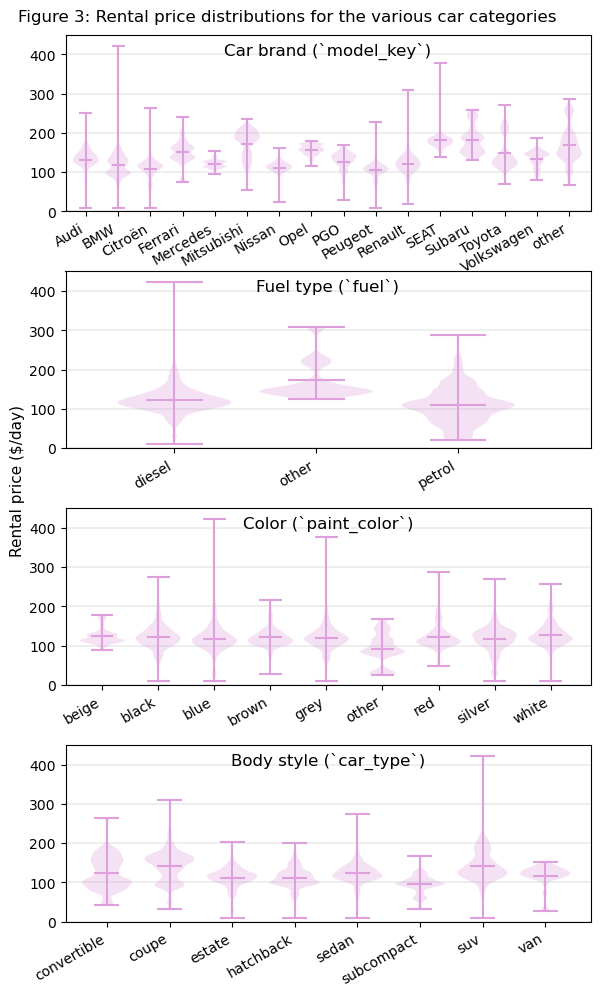

In [11]:
## Agregate categories with count < 30 into infrequent category `other`
df_ = df.loc[:, cat_vars]
value_counts = df_.apply(lambda x: x.map(x.value_counts()))
df_ = pd.concat([df_.mask(value_counts < 30, 'other'),
                 df['rental_price_per_day']], axis=1)

##
fig3, axs3 = plt.subplots(
    nrows=4, ncols=1, figsize=(6, 9.8), dpi=100,
    gridspec_kw={'left': 0.1, 'right': 0.975, 'top': 0.965, 'bottom': 0.06,
                 'hspace': 0.34})
fig3.suptitle("Figure 3: Rental price distributions for the various car categories",
              x=0.02, y=0.991, ha='left')

cat_titles = ['Car brand (`model_key`)', 'Fuel type (`fuel`)',
                'Color (`paint_color`)', 'Body style (`car_type`)']
for title, item, ax in zip(cat_titles, cat_vars, axs3):
    ax.set_title(title, y=0.84)
    vdata, categories = [], []
    for category, gdf in df_.loc[:, ['rental_price_per_day', item]].groupby(item):
        vdata.append(gdf['rental_price_per_day'].to_numpy())
        categories.append(category)
    
    n = len(categories)
    vplot = ax.violinplot(vdata, positions=np.linspace(0, n-1, n),
                          widths=0.8, showmeans=True, bw_method=0.2)
    for elt in vplot['bodies']:
        elt.set_facecolor('plum')
    for elt in ['cbars', 'cmaxes', 'cmins', 'cmeans']:
        vplot[elt].set_edgecolor('plum')
    ax.set_xlim(-0.6-0.5/n, n-0.4+1/n)
    ax.set_xticks(np.arange(0, len(categories)), categories, fontsize=10,
                  rotation=30, ha='right')
    ax.set_ylim(0, 450)
    ax.grid(visible=True, axis='y', linewidth=0.3)

fig3.text(0.02, 0.51, 'Rental price ($/day)', rotation=90, fontsize=11,
          ha='center', va='center')
    

plt.show()

Figure 3 presents violin plots of the rental prices distribution for the various car categories. We note that the aggregated categories (`other`) tend to have more inhomogeneous distributions than the others. See for instance for the car `fuel`, the infrequent category contains hybrid and electric cars, with a distribution composed of two blobs. This graph reveals that the car brand is most influencial factor for the rental price.

### Joint probability distributions of quantitative variables with rental price

In [12]:
## Rental price observations and 1D histogram bins
rental_price = df['rental_price_per_day'].to_numpy()
rp_bins = np.linspace(0, 450, 91)

## Mileage observations and 1D histogram bins
mileage = df['mileage'].to_numpy()
m_bins = np.linspace(-10_000, 1_050_000, 107)

## Engine power observations and 1D histogram bins
engine_power = df['engine_power'].to_numpy()
ep_bins = np.linspace(0, 450, 46)

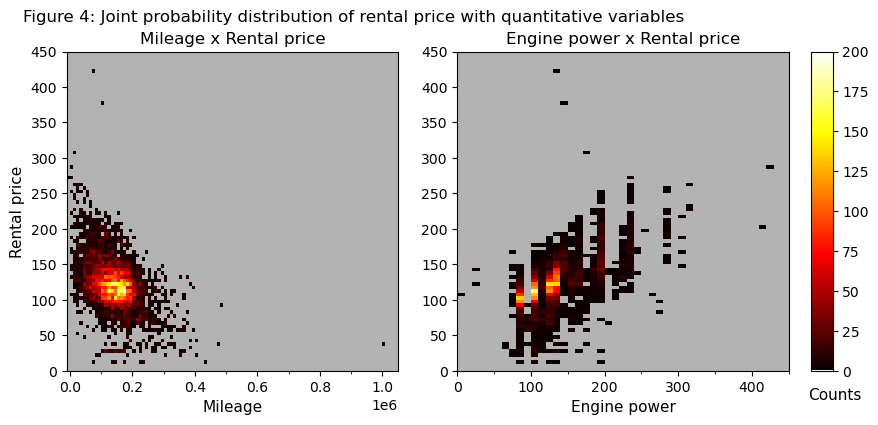

In [13]:
fig4, axs4 = plt.subplots(
    nrows=1, ncols=2, figsize=(8.8, 4.2), dpi=100,
    gridspec_kw={'left': 0.07, 'right': 0.89, 'top': 0.88, 'bottom': 0.12,
                 'wspace': 0.18})
cax4 = fig4.add_axes((0.915, 0.12, 0.025, 0.76))
fig4.suptitle("Figure 4: Joint probability distribution of rental price with quantitative variables",
              x=0.02, ha='left')



cmap4 = plt.get_cmap('hot').copy()
cmap4.set_extremes(under='0.7', over='0.5')

heatmap = axs4[0].pcolormesh(
    *np.meshgrid(m_bins, rp_bins, indexing='ij'),
    np.histogram2d(mileage, rental_price, bins=[m_bins, rp_bins])[0],
    cmap=cmap4, vmin=0.5, vmax=50)

axs4[0].set_xticks(np.linspace(1e5, 1e6, 10), minor=True)
axs4[0].set_xlabel('Mileage', fontsize=11)
axs4[0].set_yticks(np.arange(50, 500, 100), minor=True)
axs4[0].set_ylabel('Rental price', fontsize=11)
axs4[0].set_title('Mileage x Rental price')

heatmap = axs4[1].pcolormesh(
    *np.meshgrid(ep_bins, rp_bins, indexing='ij'),
    np.histogram2d(engine_power, rental_price, bins=[ep_bins, rp_bins])[0],
    cmap=cmap4, vmin=0.5, vmax=200)
axs4[1].set_xlim(0, 450)
axs4[1].set_xticks(np.arange(50, 500, 100), minor=True)
axs4[1].set_xlabel('Engine power', fontsize=11)
axs4[1].set_title('Engine power x Rental price')

fig4.colorbar(heatmap, cax=cax4, orientation="vertical", ticklocation="right")
cax4.set_yticks(np.linspace(0, 200, 9))
cax4.text(1.1, -0.09, 'Counts', fontsize=11, ha='center', transform=cax4.transAxes)

plt.show()

Figure 4 presents the joint probability distribution with the rental price of the two quantitative variables `mileage` (left panel) and `engine_power` (right panel). The grey area represents the region with no observations. Most of the distribution is confined in a small region with our choices of axes limits. However, this choice highlights clearly the outliers of the distributions. We note in particular two values with high rental price, and the very high mileage car mentioned above. The correlations with the rental price, negative for `mileage` and positive for `engine_power`, appear clearly on the graphs.

## <a id="preproc_utils"></a> Data preprocessing and utilities

Before moving on to model construction and training, we must first setup dataset preprocessing and preparation. We also introduce here some utilities relevant to model evaluation carried later on.


### Data preprocessing

The preprocessing of the dataset consists in the removal of outliers. We choose to remove those observations corresponding to high rental price and mileage using a quantile range criterion. More precisely, we discard those observations $i$ such that $x_i < m + k(Q_{0.75} - Q_{0.25})$, where $Q_{\alpha}$ is the $\alpha$-quantile and $k=6$ is an exclusion factor. We filter only the values above, since the quantities are positive by definition.

We also setup here the preprocessing pipeline that will be part of the pricing models: one-hot encoding of categorical variables and scaling of quantitative variables.

In [14]:
## Remove outliers
q1, q2 = 0.25, 0.75
k = 6 # exclusion factor
quantiles = df.loc[:, ['mileage', 'rental_price_per_day']].quantile([q1, q2])
iqr_mil, iqr_pr = quantiles.iloc[1] - quantiles.iloc[0]
med_mil, med_pr = df.loc[:, ['mileage', 'rental_price_per_day']].median()

loc = ((df['mileage'] < med_mil + k*iqr_mil)
       * (df['rental_price_per_day'] < med_pr + k*iqr_pr))
processed_df = df.loc[loc]

processed_df.describe(include='all')

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
count,4840,4840.000000,4840.000000,4840,4840,4840,4840,4840,4840,4840,4840,4840,4840,4840.000000
unique,28,NaN,NaN,4,10,8,2,2,2,2,2,2,2,NaN
top,Citroën,NaN,NaN,diesel,black,estate,True,True,False,False,False,False,True,NaN
freq,968,NaN,NaN,4638,1632,1606,2660,3838,3863,3878,2611,3671,4512,NaN
mean,NaN,140807.174587,128.992769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121.116736
std,NaN,58923.461827,39.001001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.071575
min,NaN,-64.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.000000
25%,NaN,102928.250000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.000000
50%,NaN,141084.500000,120.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119.000000
75%,NaN,175184.750000,135.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.000000


In [15]:
## data preparation
y = processed_df['rental_price_per_day']
X = processed_df.drop('rental_price_per_day', axis=1)

In [16]:
## train-test split
X_tr, X_test, y_tr, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234)

In [17]:
## column preprocessing
cat_vars = ['model_key', 'fuel', 'paint_color', 'car_type']
bool_vars = ['private_parking_available', 'has_gps', 'has_air_conditioning',
             'automatic_car', 'has_getaround_connect', 'has_speed_regulator',
             'winter_tires']
quant_vars = ['mileage', 'engine_power']
col_preproc = ColumnTransformer(
    [('cat_ohe',
      OneHotEncoder(drop=None, handle_unknown='infrequent_if_exist', min_frequency=0.005),
      cat_vars),
     ('bool_id', FunctionTransformer(feature_names_out='one-to-one'), bool_vars),
     ('quant_scaler', StandardScaler(), quant_vars)])

### Model evaluation utilities

We evaluate our model using the following metrics:
- The mean squared error (MSE), the standard evaluation of the prediction accuracy.
- The root mean squared error (RMSE), the square root of the MSE, which measures the predicition accuracy.
- The coefficient of determination $R^2$, which represent the proportion of the target variance explained by the model.
- The mean absolute error (MAE), another measure of the prediction accuracy, less sensitive to outliers.
- The mean absolute percentage error (MAPE), which measures the relative prediction accuracy.

In [18]:
## Evaluation metrics helper function
def eval_metrics(y_true: np.ndarray, y_pred: np.ndarray):
    """
    Helper function that evaluates the relevant evaluation metrics:
        MSE, RMSE, R-squared, MAE, MAPE
    """
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = 100 * mean_absolute_percentage_error(y_true, y_pred)
    return mse, np.sqrt(mse), r2, mae, mape


## Dataframe to hold the results
metric_names = ['MSE', 'RMSE', 'R2', 'MAE', 'MAPE (%)']
index = pd.MultiIndex.from_product(
    [('Ridge', 'GBM'), ('train', 'test')],
    names=['model', 'eval. set'])
evaluation_df = pd.DataFrame(
    np.full((4, 5), np.nan), index=index, columns=metric_names)

## <a id="linreg"></a> Ridge regression

We first begin by training a baseline ridge regression model.


### Parameters optimization

We introduce L2 regularization to the model because of the large number of categorical features. In order to select the appropriate value for the regularization parameter $\alpha$, we perform a grid search with cross validation.

In [19]:
## Grid search of the regularization parameter with cross validation
scoring = ('neg_mean_squared_error',  'neg_root_mean_squared_error', 'r2',
           'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error')
alphas = np.logspace(-1, 5, 61)
reg = Pipeline(
    [('column_preprocessing', col_preproc),
     ('regressor', GridSearchCV(Ridge(), param_grid={'alpha': alphas},
                                scoring=scoring, refit=False, cv=10))]
)

reg.fit(X_tr, y_tr)

Pipeline(steps=[('column_preprocessing',
                 ColumnTransformer(transformers=[('cat_ohe',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=0.005),
                                                  ['model_key', 'fuel',
                                                   'paint_color', 'car_type']),
                                                 ('bool_id',
                                                  FunctionTransformer(feature_names_out='one-to-one'),
                                                  ['private_parking_available',
                                                   'has_gps',
                                                   'has_air_conditioning',
                                                   'automatic_car',
                                                   'has_ge...
       2.51188643e+03, 3.16227766e+03, 3.98107171e+03, 5.01187234e+03,
       6.30957344e+03, 7.94328235e+03, 1.00000000e+04, 1.25892541e+04,
       1.58489319e+04, 1.99526231e+04, 2.51188643e+04, 3.16227766e+04,
       3.98107171e+04, 5.01187234e+04, 6.30957344e+04, 7.94328235e+04,
       1.00000000e+05])},
                              refit=False,
                              scoring=('neg_mean_squared_error',
                                       'neg_root_mean_squared_error', 'r2',
                                       'neg_mean_absolute_error',
                                       'neg_mean_absolute_percentage_error')))])

In [20]:
## Extract the relevant metrics
cv_res = reg['regressor'].cv_results_
rmse = -cv_res['mean_test_neg_root_mean_squared_error']
r2 = cv_res['mean_test_r2']
mae = -cv_res['mean_test_neg_mean_absolute_error']
mape = -cv_res['mean_test_neg_mean_absolute_percentage_error']

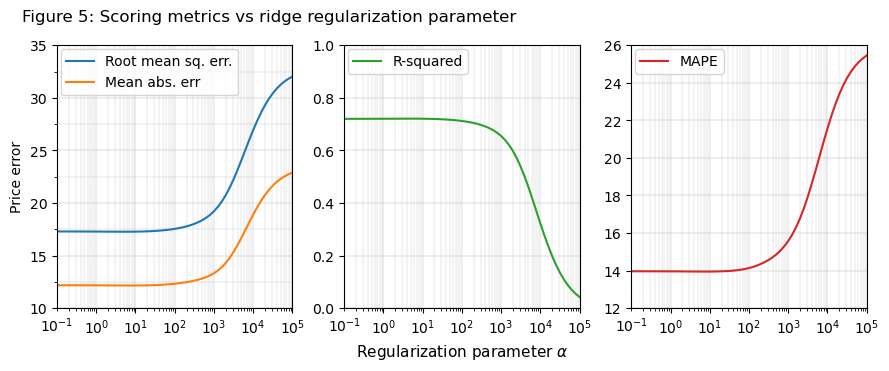

In [21]:
fig5, axs5 = plt.subplots(
    nrows=1, ncols=3, sharex=True, sharey=False, figsize=(8.8, 3.6), dpi=100,
    gridspec_kw={'left': 0.06, 'right': 0.98, 'top': 0.88, 'bottom': 0.15, 'wspace': 0.22})
fig5.suptitle("Figure 5: Scoring metrics vs ridge regularization parameter",
              x=0.02, ha='left')

# RMSE and MAE
axs5[0].plot(alphas, rmse, color='C0', label='Root mean sq. err.')
axs5[0].plot(alphas, mae, color='C1', label='Mean abs. err')
axs5[0].set_xscale('log')
axs5[0].set_xlim(1, 1e5)
axs5[0].set_xticks(np.logspace(0, 5, 6))
axs5[0].set_xticks(
    np.concatenate([np.linspace(10**i, 10**(i+1), 10) for i in range(-1, 5)]),
    minor=True)
axs5[0].set_ylim(10, 35)
axs5[0].set_yticks(np.linspace(12.5, 32.5, 5), minor=True)
axs5[0].set_ylabel('Price error')
axs5[0].grid(visible=True, linewidth=0.3)
axs5[0].grid(visible=True, which='minor', linewidth=0.2)
axs5[0].legend(loc=(0.015, 0.81))

# R-squared
axs5[1].plot(alphas, r2, color='C2', label='R-squared')
axs5[1].set_xlabel(r'Regularization parameter $\alpha$', fontsize=11)
axs5[1].set_ylim(0, 1)
axs5[1].grid(visible=True, linewidth=0.3)
axs5[1].grid(visible=True, which='minor', linewidth=0.2)
axs5[1].legend(loc=(0.015, 0.89))

# MAPE
axs5[2].plot(alphas, 100*mape, color='C3', label='MAPE')
axs5[2].set_ylim(12, 26)
axs5[2].grid(visible=True, linewidth=0.3)
axs5[2].grid(visible=True, which='minor', linewidth=0.2)
axs5[2].legend(loc=(0.015, 0.89))


plt.show()

Figure 5 presents plots of our selected metrics as a function of the regularization parameter $\alpha$ of the ridge regression. The performance of the model starts to degrade for values of $\alpha$ above $\sim 100$.

### Model training and evaluation

According to the previous results, we retain a value $\alpha = 100$ for the regularization parameter of our ridge model.

In [22]:
## Complete pipeline
ridge_model = Pipeline([('column_preprocessing', col_preproc),
                        ('regressor', Ridge(alpha=100))])

## train
ridge_model.fit(X_tr, y_tr)

## evaluate of train set
y_pred_tr = ridge_model.predict(X_tr)
evaluation_df.iloc[0] = eval_metrics(y_tr, y_pred_tr)

## evaluate on test set
y_pred_test = ridge_model.predict(X_test)
evaluation_df.iloc[1] = eval_metrics(y_test, y_pred_test)

In [23]:
evaluation_df.loc['Ridge']

,MSE,RMSE,R2,MAE,MAPE (%)
eval. set,,,,,
train,302.900604,17.40404,0.720073,12.198836,14.008746
test,368.880038,19.20625,0.675800,12.990555,16.596385


The performance of the model is acceptable, with $R^2 \simeq 0.7$. The mean absolute error is about 12-13, significantly lower than the root mean squared error (17-19). This indicates that our model deals poorly with outliers. This can be caused by the aggregation of infrequent categories that may correspond large price differences (especially the car brand).

The metrics are significantly better for the train set than for the test set (300 vs 370 mean squared error), indicating an important overfitting of the model. Another possible explanation could be that the test set contains many observations with values in the infrequent categories, on which the model will fail to produce good results.

### Model interpretation

We inspect the model coefficients to determine which variables are relevant to rental price.

In [24]:
## Recover feature names
col_preproc_ = ridge_model['column_preprocessing']
features = ['intercept']
features += [feature_name.split('__')[1].split('_sklearn')[0]
             for feature_name in col_preproc_.get_feature_names_out()]

## Get coefficients
intercept = ridge_model['regressor'].intercept_
coef_vals = np.concatenate([[intercept], ridge_model['regressor'].coef_])


for feature, coef in zip(features, coef_vals):
    print(f'{feature:<26} : {coef:>6.2f}')

intercept                  : 105.22
model_key_Audi             :  -2.09
model_key_BMW              :  -5.40
model_key_Citroën          :  -6.40
model_key_Ferrari          :   0.92
model_key_Mercedes         :   4.68
model_key_Mitsubishi       :   4.83
model_key_Nissan           :  -8.13
model_key_Opel             :   2.40
model_key_PGO              :  -4.22
model_key_Peugeot          :  -2.46
model_key_Renault          :   2.81
model_key_SEAT             :   4.59
model_key_Subaru           :   2.02
model_key_Toyota           :   2.15
model_key_Volkswagen       :   2.88
model_key_infrequent       :   1.42
fuel_diesel                :   6.84
fuel_petrol                :  -7.98
fuel_infrequent            :   1.15
paint_color_beige          :   0.05
paint_color_black          :   0.85
paint_color_blue           :  -2.00
paint_color_brown          :   1.34
paint_color_grey           :  -0.16
paint_color_red            :   0.87
paint_color_silver         :  -2.40
paint_color_white          :

The two most important factors influencing the rental price are the mileage and engine power. This is in agreement with what was observed on the correlation matrix (see figure 2). The presence of car options, especially GPS, is also important to the pricing. Within a given categorical feature, some categories appear have an important offset with the average price (intercept) while other do not. Compare for instance `car_type_suv` and `car_type_sedan`. This could be an artefact of the strong correlation between the prediction features.

## <a id="gbm"></a> Gradient Boosting model

We complete the pricing models catalogue of our application by training a gradient boosting regressor.


### Parameters optimization

In [25]:
## Grid search of the regularization parameter with cross validation
scoring = ('neg_mean_squared_error',  'neg_root_mean_squared_error', 'r2',
           'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error')
n_estimators_vals = np.arange(100, 1001, 100)
reg = Pipeline(
    [('column_preprocessing', col_preproc),
     ('regressor', GridSearchCV(GradientBoostingRegressor(random_state=1234),
                                param_grid={'n_estimators': n_estimators_vals},
                                scoring=scoring, refit=False, cv=5))]
)

reg.fit(X_tr, y_tr)

Pipeline(steps=[('column_preprocessing',
                 ColumnTransformer(transformers=[('cat_ohe',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=0.005),
                                                  ['model_key', 'fuel',
                                                   'paint_color', 'car_type']),
                                                 ('bool_id',
                                                  FunctionTransformer(feature_names_out='one-to-one'),
                                                  ['private_parking_available',
                                                   'has_gps',
                                                   'has_air_conditioning',
                                                   'automatic_car',
                                                   'has_ge...
                                                  StandardScaler(),
                                                  ['mileage',
                                                   'engine_power'])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=GradientBoostingRegressor(random_state=1234),
                              param_grid={'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])},
                              refit=False,
                              scoring=('neg_mean_squared_error',
                                       'neg_root_mean_squared_error', 'r2',
                                       'neg_mean_absolute_error',
                                       'neg_mean_absolute_percentage_error')))])

In [26]:
## Extract the relevant metrics
cv_res = reg['regressor'].cv_results_
rmse = -cv_res['mean_test_neg_root_mean_squared_error']
r2 = cv_res['mean_test_r2']
mae = -cv_res['mean_test_neg_mean_absolute_error']
mape = -cv_res['mean_test_neg_mean_absolute_percentage_error']

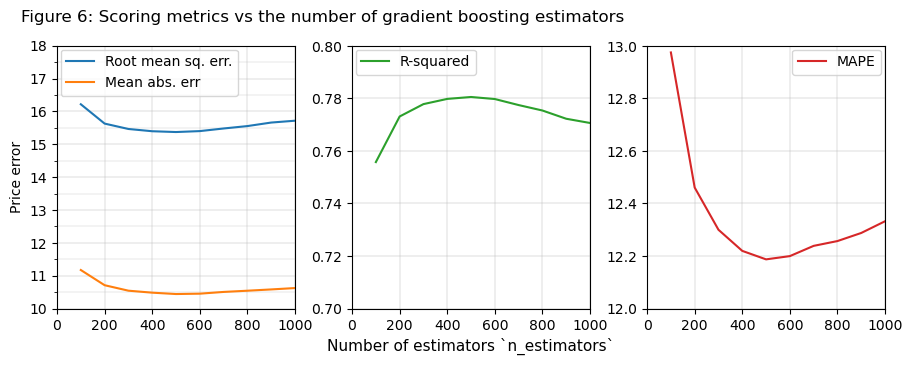

In [27]:
fig6, axs6 = plt.subplots(
    nrows=1, ncols=3, sharex=True, sharey=False, figsize=(9, 3.6), dpi=100,
    gridspec_kw={'left': 0.06, 'right': 0.98, 'top': 0.88, 'bottom': 0.15, 'wspace': 0.24})
fig6.suptitle("Figure 6: Scoring metrics vs the number of gradient boosting estimators",
              x=0.02, ha='left')

# RMSE and MAE
axs6[0].plot(n_estimators_vals, rmse, color='C0', label='Root mean sq. err.')
axs6[0].plot(n_estimators_vals, mae, color='C1', label='Mean abs. err')
axs6[0].set_xlim(0, 1000)
axs6[0].set_ylim(10, 18)
axs6[0].set_yticks(np.linspace(10.5, 17.5, 8), minor=True)
axs6[0].set_ylabel('Price error')
axs6[0].grid(visible=True, linewidth=0.3)
axs6[0].grid(visible=True, which='minor', linewidth=0.2)
axs6[0].legend(loc=(0.015, 0.81))

# R-squared
axs6[1].plot(n_estimators_vals, r2, color='C2', label='R-squared')
axs6[1].set_xlabel(r'Number of estimators `n_estimators`', fontsize=11)
axs6[1].set_ylim(0.7, 0.8)
axs6[1].grid(visible=True, linewidth=0.3)
axs6[1].grid(visible=True, which='minor', linewidth=0.2)
axs6[1].legend(loc=(0.015, 0.89))

# MAPE
axs6[2].plot(n_estimators_vals, 100*mape, color='C3', label='MAPE')
axs6[2].set_ylim(12, 13)
axs6[2].grid(visible=True, linewidth=0.3)
axs6[2].grid(visible=True, which='minor', linewidth=0.2)
axs6[2].legend(loc=(0.61, 0.89))


plt.show()

Figure 6 presents plots of our selected metrics as a function of the number of estimators used with the gradient boosting regressor. The metrics reach an optimum for `n_estimators = 500`, which we retain for the model.

### Model training and evaluation

In [28]:
## Complete pipeline
gb_model = Pipeline(
    [('column_preprocessing', col_preproc),
     ('regressor', GradientBoostingRegressor(n_estimators=500, random_state=1234))]
)

## train
gb_model.fit(X_tr, y_tr)

## evaluate of train set
y_pred_tr = gb_model.predict(X_tr)
evaluation_df.iloc[2] = eval_metrics(y_tr, y_pred_tr)

## evaluate on test set
y_pred_test = gb_model.predict(X_test)
evaluation_df.iloc[3] = eval_metrics(y_test, y_pred_test)

In [29]:
evaluation_df

MSE       RMSE        R2        MAE   MAPE (%)
model eval. set                                                       
Ridge train      302.900604  17.404040  0.720073  12.198836  14.008746
      test       368.880038  19.206250  0.675800  12.990555  16.596385
GBM   train      144.302489  12.012597  0.866642   8.244311   9.476215
      test       255.668401  15.989634  0.775299  10.215427  13.599528

The gradient boosting model is more performant than the simple ridge model. However, overfitting is still present, and even worse than for ridge regression. Nevertheless, the test set metrics are quite close to those obtained by cross-validation (see figure 6).